# Part I: Supervised Learining 

In [1]:
import os
import os.path
import time
from datetime import datetime
import numpy as np
import math
import matplotlib.pyplot as plt 
import scipy
import scipy.io as spio
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import urllib
import urllib.request
from urllib.request import urlopen
%matplotlib inline

In [2]:
link = "http://www0.cs.ucl.ac.uk/staff/M.Herbster/SL/misc/zipcombo.dat"
training_filename = 'dtrain123.dat'
test_filename = 'dtest123.dat'
filename = 'zipcombo.dat'

# If we have already downloaded the file then read from it
if os.path.isfile(filename): 
    data = np.loadtxt(filename)
else:
    # Otherwise, just download it and then load it in memory
    urllib.request.urlretrieve(link, filename)
    data = np.loadtxt(filename)
    
y = data[:,0]
x = data[:,1:]

## Multiclass Perceptron with Polynomial Kernel

In [3]:
def Polynomial_Kernel(x1,x2,d):
    """
    Constructions the polynomial kernel matrix of order d
    :param x1: the first set of observations
    :param x2: the second set of observations
    :param d: the order of polynomial
    :return: the polynomial kernel
    """
    K = (x1 @ x2.T)**d
    return K

def transform_y(y):
    """
    Helper function used in perceptron weight updating. This transforms y from a vector containing digits
    into a matrix where each row i represents an observation and each column j denotes with {-1,1} whether the
    observation i label was of column j.
    :param y: the label vector y
    :return: a transformed y matrix
    """
    classes_num = 10
    m = len(y)
    y_matrix = np.ones((m,classes_num))*(-1)
    for i in range(m):
        y_matrix[i,int(y[i])] = 1
    return y_matrix

def pairwise_distance_single(X): # distances of X training data, single X matrix
    """
    Computes the pairwise distance for a single X matrix
    :param X: the matrix for which we need to compute the pairwise distances
    :return: the pairwise distances matrix
    """
    m = X.shape[0]
    n = X.shape[1]
    G = np.matmul(X,X.T)
    DG = np.diag(G).reshape(G.shape[0],1)
    distances_sq = np.matmul(DG,np.ones((G.shape[0],1)).T)+ np.matmul(np.ones((G.shape[1],1)),DG.T)-2.0*G
    return distances_sq

def pairwise_distance_double(X1,X2): # distances of X training data, double matrices, X1 and X2
    """
    Computes the pairwise distance for two matrices X1 and X2
    :param X1: the first matrix
    :param X2: the second matrix
    :return: the pairwise distances matrix
    """
    X1_pow = (X1**2).sum(axis=1).reshape(X1.shape[0],1) #sum the rows, size m1 array
    X2_pow = (X2**2).sum(axis=1).reshape(X2.shape[0],1) #sum the rows, size m2 array
    G = np.matmul(X1,X2.T)
    m1,m2 =G.shape[0],G.shape[1] 
    distances_sq = np.matmul(X1_pow,np.ones((m2,1)).T)+ np.matmul(np.ones((m1,1)),X2_pow.T)-2.0*G
    return distances_sq

def Gaussian_Kernel(distances_sq,c=1):
    """
    Given a matrix which contains the pairwise distances, it calculates the gaussian kernel
    :param distances_sq: the pairwise distances matrix
    :param c: the constant scale of the exponential factor
    :return: the kernel matrix K
    """
    K = np.exp(-c*distances_sq)
    return K

In [44]:
def calculate_kernel_single(x, d, kernel_choice):
    """
    Calculates the kernel function of matrix x.
    :param x: the observations matrix
    :param d: is either the order of the polynomial kernel or the constant in the gaussian kernel
    :param kernel_choice: Depending on the kernel choice, can be {'Polynomial', 'Gaussian'}
    :return: the kernel matrix
    """
    if kernel_choice=='Polynomial':
        K_train = Polynomial_Kernel(x,x,d)
    elif kernel_choice=='Gaussian':
        pairwise_distances = pairwise_distance_single(x)
        K_train = Gaussian_Kernel(pairwise_distances,c=d)
    else:
        raise Exception("Unsupported value for kernel. Supported values: Polynomial, Gaussian")
    return K_train

def calculate_kernel_double(x1, x2, d, kernel_choice):
    """
    Calculates the kernel function of matrix x1 and x2.
    :param x1: the first matrix x1
    :param x2: the first matrix x2
    :param d: is either the order of the polynomial kernel or the constant in the gaussian kernel
    :param kernel_choice: Depending on the kernel choice, can be {'Polynomial', 'Gaussian'}
    :return: the kernel matrix
    """
    if kernel_choice=='Polynomial':
        K_train = Polynomial_Kernel(x1,x2,d)
    elif kernel_choice=='Gaussian':
        pairwise_distances = pairwise_distance_double(x1, x2)
        K_train = Gaussian_Kernel(pairwise_distances,c=d)
    else:
        raise Exception("Unsupported value for kernel. Supported values: Polynomial, Gaussian")
    return K_train

def perceptron_epoch(x, y, y_arr, alpha, K_train):
    """
    Given a set of weights alpha, this function goes through the whole set of examples in x, one by one
    and iteratively update the weights if a mistake has happened.
    :param x: the observations array
    :param y: the labels vector
    :param y_arr: the transformed labels matrix
    :param alpha: the set of weights
    :param K_train: the kernel matrix as calculated over x
    :return: the updated weights alpha and the number of errors made while going through the points
    """
    # Number of examples
    m = x.shape[0] 
    errors = np.zeros(m)
    num_errors = 0

    for t in range(m):
        # Find our training set
        x_t = x[t,:] #n size (1,n)
        y_t = y[t]
        y_arr_t = y_arr[t,:] # size (1,10) 

        # pred_t computes \sum^{t-1}_{i=0} {(alpha_i K(x_t, x_i))}, 
        # which is regarded as the confidence in each class
        pred_t = (alpha[:,:].T @K_train[t,:]).T
        y_hat_t = np.where(pred_t == max(pred_t), 1, 0) # map the confidence to arrays of 1 and 0 for class

        if pred_t.argmax() != y_t:
            # Update the alpha, and weights, for all the classes that not the true class
            num_errors +=1

            # Note that alpha_t is np.zeros(10,1), 
            # and alpha_t is updated according to the real class, and the misclassified class.
            alpha_t = alpha[t,:] + np.where(y_arr_t> 0,1,0) + np.where(y_hat_t>0,-1,0) #(1,10)

            # Store alpha_t into the matrix for future reference
            alpha[t,:] = alpha_t

            # Sandwich K(x_t, x_i) for i in [1,t-1] in a zeros array of size(m). 
            # Reason being weight for one class is of size(m), 
            # but we only 'have enough data' to update the first t-1 terms.  
            K_update = np.zeros((1,m))
            K_update[:,:t] = K_train[t,:t]

        errors[t] = num_errors
    return alpha, errors

# One vs. rest: train k classifiers to identify k classes
def perceptron_train(x, y, d=2, kernel_choice='Polynomial', convergence_threshold=0.01):
    """
    Trains a perceptron based on the one vs. rest approach, i.e. train k classifiers to identify k classes
    :param x: the observations array
    :param y: the labels vector
    :param d: is either the order of the polynomial kernel or the constant in the gaussian kernel
    :param kernel_choice: Depending on the kernel choice, can be {'Polynomial', 'Gaussian'}
    :param convergence_threshold: the threshold value upon we stop updating the perceptron, if the difference
    in errors was smaller than that
    :return:
    """
    m = x.shape[0] #number of examples
    n = x.shape[1] #number of features
    classes_num = 10 #number of classes 
     
    error_per_epoch = []
    y_arr = transform_y(y) 
    alpha = np.zeros((m,classes_num)) #Need to store alpha array at all iteration, as we need it to compute confidence
    
    K_train = calculate_kernel_single(x, d, kernel_choice)    
    epochs = 0
    while True:
        alpha, errors = perceptron_epoch(x, y, y_arr, alpha, K_train)
        
        error_rate_current = error_per_epoch[-1] / x.shape[0] if epochs > 0 else 0
        error_rate_next = errors[-1] / x.shape[0]

        error_per_epoch.append(errors[-1])
        if epochs > 0 and (error_rate_next > error_rate_current or \
            error_rate_current - error_rate_next < convergence_threshold):
            break
            
        epochs += 1

    return alpha, error_per_epoch

# Q1 - Basic Results

In [8]:
def allocate_training_test_sets(data,r =1/5):
    """
    Given a matrix M, of MxN dimensions, it splits it into (1 - r) and r sizes
    for a training and test set respectively and separates it into X and Y,
    assuming that the last column of the matrix denotes Y
    :param data: the matrix to split
    :param r: the ratio of test to train data
    :return: the training set arrays X_train and y_train and
          test set arrays X_test and y_test
    """
    X = data[:,1:]
    y = data[:,0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=r, shuffle=True)    
    return X_train, X_test, y_train, y_test

In [9]:
def perceptron_test(x_test,x_train,y_test, alphas, d, kernel_choice='Polynomial'):
    """
    This function predicts the labels for a given set of observations.
    :param x_test: the set of observations to predict
    :param x_train: the observations in which the perceptron has been trained on
    :param y_test: the true labels of x_test
    :param alphas: the set of weights of the perceptron
    :param d: is either the order of the polynomial kernel or the constant in the gaussian kernel
    :param kernel_choice: Depending on the kernel choice, can be {'Polynomial', 'Gaussian'}
    :return: the number of mistakes that the perceptron made, the predictions as well as the confidence values.
    """
    # Calculate the Kernel matrix
    K_test = calculate_kernel_double(x_train, x_test, d, kernel_choice)
    
    # Compute the confidence
    confidence = (alphas.T @ K_test).T
    
    # Compute mistakes and predictions
    preds = np.zeros(confidence.shape)
    mistakes = 0
    for i in range(y_test.shape[0]):
        y_hat = confidence[i].argmax()
        preds[i,y_hat] = 1
        if y_hat != y_test[i]:
            mistakes += 1
            
    return mistakes, preds, confidence

In [10]:
def basic_results(d_arr, kernel_choice, runs):
    """
    For every value in d_arr, and using the kernel specified in kernel_choice,
    it performs "runs" iterations where it trains a perceptron based on randomly selected
    80% of the data and tests on the rest 20%.
    :param d_arr: an array of d values
    :param kernel_choice: Depending on the kernel choice, can be {'Polynomial', 'Gaussian'}
    :param runs: the number of runs to perform
    :return: two arrays: one containing the errors recorded in the training set in every run and one for the test set.
    """
    d_length = len(d_arr)
    training_set_errors = np.zeros((d_length,runs))
    test_set_errors = np.zeros((d_length,runs))
    
    for d in d_arr:
        for i in range(runs):
            print("Now doing run ", i+1, "/", runs, " for d=", d,".........", end='\r')
            X_train, X_test, y_train, y_test = allocate_training_test_sets(data, r=1/5)
            alphas,_ = perceptron_train(X_train, y_train, d, kernel_choice=kernel_choice)

            train_errors,_,_ = perceptron_test(X_train, X_train, y_train, alphas, d, kernel_choice=kernel_choice)
            test_errors,_,_ = perceptron_test(X_test, X_train, y_test, alphas, d, kernel_choice=kernel_choice)

            training_set_errors[d-1, i] = train_errors / y_train.shape[0]
            test_set_errors[d-1, i] = test_errors / y_test.shape[0]
    return training_set_errors, test_set_errors

In [128]:
d_arr = np.arange(1,8)
runs = 20

startTime = datetime.now()
training_set_errors_pp_basic, test_set_errors_pp_basic = basic_results(d_arr, 'Polynomial', runs)
time_pp_basic = datetime.now() - startTime
print("\nTime taken: ", time_pp_basic)

Time taken:  0:12:53.117431 d= 7 .........


In [11]:
def construct_dataframe_error_rates(training_set_errors, test_set_errors, d_arr):
    """
    Transformes the two training and test set error arrays into one, so as to be digested in a panda dataframe.
    :param training_set_errors: an array containing the error recorded in the training set in every run.
    :param test_set_errors: an array containing the error recorded in the test set in every run.
    :param d_arr: an array of d values
    :return: a zipped array containing the mean and standard deviation of errors in the training and test set for every
    d value, as calculated upon all the runs.
    """
    means_std = []
    for d in range(len(d_arr)):
        data_t = []
        data_t.append("{0:.4f} +- {1:.4f}".format(training_set_errors[d].mean(), \
                                                np.std(training_set_errors[d])))
        data_t.append("{0:.4f} +- {1:.4f}".format(test_set_errors[d].mean(), \
                                                np.std(test_set_errors[d])))
        means_std.append(data_t)
    return means_std
    
means_std = construct_dataframe_error_rates(training_set_errors, test_set_errors, d_arr)
df = pd.DataFrame(data=means_std, index=d_arr, columns=['Training set error rate', 'Test set error rate'])
df

,Training set error rate,Test set error rate
1,0.0807 +- 0.0210,0.1003 +- 0.0229
2,0.0153 +- 0.0042,0.0470 +- 0.0054
3,0.0074 +- 0.0031,0.0403 +- 0.0052
4,0.0058 +- 0.0036,0.0358 +- 0.0055
5,0.0032 +- 0.0016,0.0325 +- 0.0043
6,0.0025 +- 0.0013,0.0331 +- 0.0044
7,0.0074 +- 0.0235,0.0394 +- 0.0237


# Q2 - Cross Validation

Having already allocated x_train, now perform cross validation on x_train

In [89]:
def cross_validation(X, y, kernel_choice, d, k):
    """
    This function performs a k-fold cross validation on X, using a kernel of "kernel_choice" with parameter d.
    :param X: the observations array
    :param y: the labels vector
    :param kernel_choice: Depending on the kernel choice, can be {'Polynomial', 'Gaussian'}
    :param d: the parameter of the kernel
    :param k: the number of splits, i.e. the k parameter in k-fold Cross Validation
    :return: the mean of test error across the k runs of the CV process and its standard deviation
    """
    kf = KFold(n_splits=k, shuffle=True)
    MSE_cv_arr = np.zeros(k)
    i = 0
    
    for train_index, cv_index in kf.split(X):
        # Spit the matrix using the indices gained by the CV method and construct X and Y arrays
        X_train = X[train_index]
        X_cv = X[cv_index]
        y_train = y[train_index]
        y_cv = y[cv_index]
    
        # We are only interested in the alphas and not the MSE on the training set
        alphas, errors = perceptron_train(X_train, y_train, d, kernel_choice = kernel_choice)
        mistakes,_,_ = perceptron_test(X_cv, X_train, y_cv, alphas, d, kernel_choice = kernel_choice)
        MSE_cv_arr[i] = mistakes / len(y_cv)
        i += 1
        
    return MSE_cv_arr.mean(), np.std(MSE_cv_arr)

def cv_process(d_arr, runs, kernel_choice, calculate_confusions):
    """
    This function performs 5-fold cross validation, multiple times (specified by runs argument) across the different
    values of d specified in d_arr using the kernel specified in kernel_choice
    :param d_arr: an array of d values
    :param runs: The number of runs to repeat the CV process
    :param kernel_choice: Depending on the kernel choice, can be {'Polynomial', 'Gaussian'}
    :param calculate_confusions: Whether or not to also calculate confusions on the test set
    :return: the array of d_stars, the test_errors and the confusions found
    """
    d_stars = np.zeros(runs)
    test_errors = np.zeros(runs)
    confusions = []
    
    if runs != 20:
        print("WARNING: Change the number of runs to 20!!!")
        
    for run in range(runs):
        confusion = np.zeros((10, 10))

        # In each run we will iterate through the d array and use all possible values of d
        # Allocate 80/20 percent for training and test set
        X_train, X_test, y_train, y_test = allocate_training_test_sets(data, r=1/5)

        CV_means = np.zeros(len(d_arr))
        for i in range(len(d_arr)):
            print("Now doing run ", run+1, "/", runs, " for d=", d_arr[i], ".........", end='\r')
            MSE_CV_mean, _ = cross_validation(X_train, y_train, kernel_choice, d_arr[i], k=5)
            CV_means[i] = MSE_CV_mean

        # Train in whole 80% now with d_star
        d_stars[run] = d_arr[CV_means.argmin()]
        alphas, errors = perceptron_train(X_train, y_train, d_stars[run], kernel_choice = kernel_choice)

        mistakes,preds_test,_ = perceptron_test(X_test, X_train, y_test, alphas, d_stars[run], kernel_choice = kernel_choice)
        test_errors[run] = mistakes / len(y_test)
                        
        if calculate_confusions:
            for i in range(X_test.shape[0]):
                pred_label = preds_test[i].argmax()
                if preds_test[i].argmax() != y_test[i]:
                    confusion[int(y_test[i]), pred_label] += (1 / mistakes)
            
            confusions.append(confusion)
            
    return d_stars, test_errors, confusions

In [90]:
runs = 20
startTime = datetime.now()
d_stars_array, test_errors_array, confusions_array = cv_process(d_arr, runs, 'Polynomial', True)
time_pp_cv = datetime.now() - startTime

In [146]:
print("Time taken: ", time_pp_cv)

Time taken:  0:32:27.296995


In [95]:
print("Mean d*: ", d_stars_array.mean(), " with std: ", np.std(d_stars_array))
print("Mean test error: ", test_errors_array.mean(), " with std: ", np.std(test_errors_array))

Mean d*:  5.4  with std:  0.8
Mean test error:  0.03545698924731183  with std:  0.00511311239579829


# Q3 - Confusion Matrix

In [94]:
confusions_matrix = []
for i in range(10):
    confusions_i = []
    for j in range(10):
        confusions_ij = np.asarray([confusions_array[r][i,j] for r in range(runs)])
        confusions_i.append("{0:.2f} +- {1:.2f}".format(confusions_ij.mean(), np.std(confusions_ij)))
    confusions_matrix.append(confusions_i)
    
df = pd.DataFrame(data=confusions_matrix)
df

,0,1,2,3,4,5,6,7,8,9
0,0.00 +- 0.00,0.00 +- 0.00,0.02 +- 0.02,0.01 +- 0.02,0.01 +- 0.01,0.01 +- 0.01,0.01 +- 0.01,0.00 +- 0.01,0.01 +- 0.01,0.00 +- 0.01
1,0.00 +- 0.00,0.00 +- 0.00,0.00 +- 0.01,0.00 +- 0.00,0.03 +- 0.04,0.00 +- 0.00,0.01 +- 0.01,0.00 +- 0.01,0.01 +- 0.02,0.00 +- 0.01
2,0.01 +- 0.02,0.00 +- 0.01,0.00 +- 0.00,0.02 +- 0.02,0.02 +- 0.02,0.00 +- 0.01,0.01 +- 0.01,0.02 +- 0.02,0.01 +- 0.02,0.00 +- 0.01
3,0.01 +- 0.01,0.00 +- 0.01,0.03 +- 0.02,0.00 +- 0.00,0.00 +- 0.00,0.05 +- 0.02,0.00 +- 0.00,0.01 +- 0.01,0.03 +- 0.03,0.00 +- 0.00
4,0.00 +- 0.01,0.02 +- 0.02,0.01 +- 0.02,0.00 +- 0.00,0.00 +- 0.00,0.00 +- 0.01,0.01 +- 0.02,0.01 +- 0.02,0.01 +- 0.01,0.03 +- 0.03
5,0.02 +- 0.02,0.00 +- 0.01,0.01 +- 0.01,0.05 +- 0.04,0.01 +- 0.01,0.00 +- 0.00,0.02 +- 0.02,0.00 +- 0.01,0.02 +- 0.02,0.01 +- 0.01
6,0.02 +- 0.02,0.01 +- 0.01,0.01 +- 0.01,0.00 +- 0.00,0.01 +- 0.01,0.01 +- 0.01,0.00 +- 0.00,0.00 +- 0.00,0.00 +- 0.01,0.00 +- 0.01
7,0.00 +- 0.00,0.01 +- 0.01,0.01 +- 0.02,0.00 +- 0.01,0.01 +- 0.02,0.00 +- 0.00,0.00 +- 0.00,0.00 +- 0.00,0.01 +- 0.01,0.03 +- 0.02
8,0.01 +- 0.02,0.01 +- 0.02,0.01 +- 0.02,0.04 +- 0.02,0.01 +- 0.02,0.03 +- 0.02,0.01 +- 0.01,0.02 +- 0.02,0.00 +- 0.00,0.01 +- 0.01
9,0.00 +- 0.01,0.01 +- 0.01,0.00 +- 0.01,0.00 +- 0.01,0.03 +- 0.02,0.00 +- 0.01,0.00 +- 0.00,0.04 +- 0.03,0.00 +- 0.01,0.00 +- 0.00


# Q4 - Hardest numbers to predict

In [16]:
def plot_hardest_images(indices):
    """
    This helper function plots images in an 1x(len(indices)) grid of plots.
    :param indices: The indices of examples to plot (from array 'x')
    """
    plt.figure(figsize=(30,30))
    k = 1
    for i in indices:
        a1 = plt.subplot(1, len(indices), k)
        pixels = np.array(x[i], dtype='uint8')
        pixels = pixels.reshape((16, 16))
        plt.title("Real: {0}".format(y[i]))
        a1.imshow(pixels, cmap='gray')
        k+=1
        
def find_hardest_elements(x, y, d_star, runs, k_splits=5):
    """
    This function performs a number of runs over the data set in order to find the 5 images which are the most
    difficult to predict. The way this process is done is the following:
        - We perform a 5-fold split over the data set, dividing into 80% for training and 20% for testing
        - We use the mean d_star as calculated over 20 runs of CV in the data set, to train a perceptron on the 80%
          of the data set.
        - We predict the remaining 20% and we store the confidences we obtain in each split and run
    At the end of the process, we sort the confidences in ascending order and return the 5 first indices
    (i.e. the observations which were harder to predict)
    :param x: the observations array
    :param y: the labels vector
    :param d_star: the value of d to use while training the perceptron
    :param runs: the number of runs to perform
    :param k_splits: the number of splits to perform while generating the training/test sets.
    :return: the indices of the elements of x, that we predict the least confidence with
    """
    least_confidences = np.zeros(data.shape[0])
    
    for run in range(runs):
        print("Finding hardest elements, run ", run+1, "/", runs,".....", end='\r')
        
        # Split into 80%/20% for training and test set
        kf = KFold(n_splits=k_splits, shuffle=True)
        for train_index, test_index in kf.split(x):
            X_train = x[train_index]
            X_test = x[test_index]
            y_train = y[train_index]
            y_test = y[test_index]

            alphas,_ = perceptron_train(X_train, y_train, d_star)
            _, preds_test, confidences = perceptron_test(X_test, X_train, y_test, alphas, d_star)
            
            for i in range(X_test.shape[0]):
                pred_label = preds_test[i].argmax()
                least_confidences[test_index[i]] += confidences[i][int(y_test[i])] / 5
    
    least_confidences /= runs

    conf_indices = np.argsort(least_confidences)[:5]
    return conf_indices, np.sort(least_confidences)[:5]

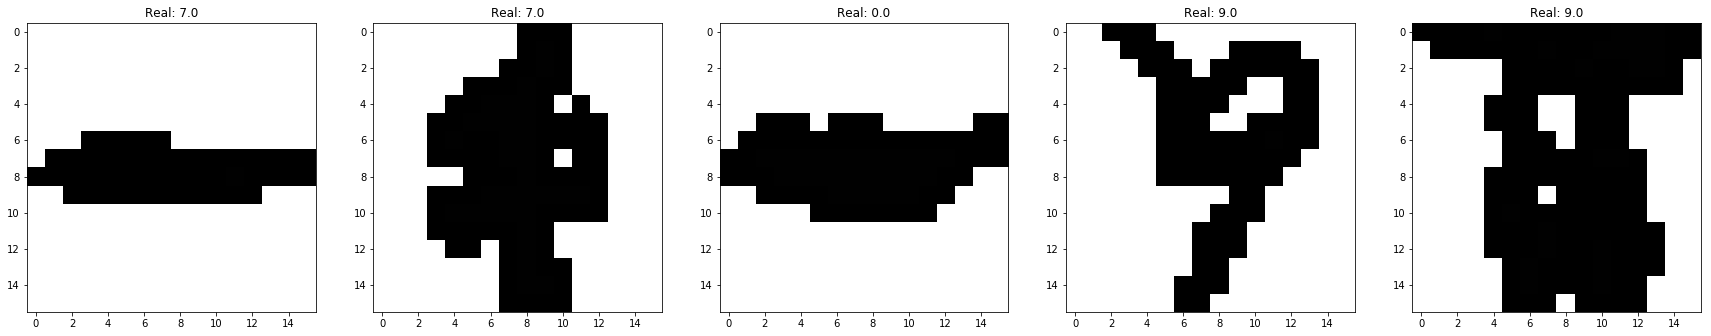

In [17]:
conf_indices, least_confidences = find_hardest_elements(x, y, int(d_stars.mean()), runs=20)
plot_hardest_images(conf_indices)

# Q5 - Gaussian Kernel

In [130]:
runs = 20
d_arr = np.arange(1,8)

startTime = datetime.now()
training_set_errors_gaussian, test_set_errors_gaussian = basic_results(d_arr, 'Gaussian', runs)
time_pg_cv = datetime.now() - startTime
print("Time taken: ", time_pg_cv)

means_std = construct_dataframe_error_rates(training_set_errors_gaussian, test_set_errors_gaussian, d_arr)
df = pd.DataFrame(data=means_std, index=d_arr, columns=['Training set error rate', 'Test set error rate'])
df

Time taken:  0:28:48.390727 d= 7 .........


,Training set error rate,Test set error rate
1,0.0000 +- 0.0000,0.0621 +- 0.0057
2,0.0000 +- 0.0000,0.0625 +- 0.0042
3,0.0000 +- 0.0001,0.0624 +- 0.0052
4,0.0000 +- 0.0000,0.0633 +- 0.0063
5,0.0000 +- 0.0000,0.0649 +- 0.0051
6,0.0000 +- 0.0000,0.0746 +- 0.0044
7,0.0001 +- 0.0001,0.0967 +- 0.0066


In [131]:
#Cross Validation with Gaussian Kernel, find d_star
runs = 20
startTime = datetime.now()
d_stars_gaussian2, test_errors_gaussian2, confusions2 = cv_process(d_arr, runs, 'Gaussian', False)
time_pg_cv2 = datetime.now() - startTime
print("Time taken: ", time_pg_cv2)
print("Mean d*: ", d_stars_gaussian2.mean(), " with std: ", np.std(d_stars_gaussian2))
print("Mean test error: ", test_errors_gaussian2.mean(), " with std: ", np.std(test_errors_gaussian2))

Time taken:  1:01:32.725772 d= 7 .........
Mean d*:  2.9  with std:  1.1357816691600546
Mean test error:  0.06196236559139785  with std:  0.00670832242659558


# Q6 - Choose an alternative method to generalise k-classes

In [20]:
#One vs. one approach: train k*(k-1)/2 binary classifiers to identify k classes
#For example, one classifier could be trained to distinguish between digit 0 and digit 1.
#Consider symmetry when computing prediction

# Write a function that trains a binary classifier given two classes, given kernel:
def classifier_ovo(class1,class2,K,alpha_ovo,iter_num):
    """
    Given a kernel K and a set of weights, this function returns the signs denoting the votes of the one-versus-one
    classifier
    :param K: the kernel matrix K
    :param alpha_ovo: the set of weights for the one-versus-one classifiers
    :param iter_num: the number of iteration we are in
    :return: a vote, within (-1,1)
    """
    vote = np.sign(((alpha_ovo[:].T @K[iter_num,:]).T))
    return vote #returns a vote, within (-1,1)

def perceptron_train_ovo(x,y,d=2,kernel_choice='Polynomial',max_epoch=10, tol=0.01):
    """
    This function trains the classifiers needed for the one-versus-one approach of perceptron
    :param x: the observations array
    :param y: the labels vector
    :param d: the value of d used in the calculation of the kernel matrix
    :param kernel_choice: Depending on the kernel choice, can be {'Polynomial', 'Gaussian'}
    :param max_epoch: the maximum number of epochs to perform while training the perceptrons
    :param tol: a threshold value which denotes the minimum change in error rate that we should have
    in order to continue training
    :return: a set of weights alpha (matrix of (m X n X n), where m is the number of examples,
    n is the number of classes) and the number of errors in the last epoch
    """
    m = x.shape[0] #number of examples
    n = x.shape[1] #number of features
    classes_num = 10 #number of classes 
    error_per_epoch = np.zeros(max_epoch)
    errors = np.zeros(m)
    K_train = calculate_kernel_single(x, d, kernel_choice)
    
    num_errors = 0 
    alpha = np.zeros((m,classes_num,classes_num)) 
    
    for epoch in range(max_epoch):
        errors = np.zeros(m)
        num_errors = 0 #This should be bounded..? Maybe calculate the bound in the explanation
    
        #iterate through training set
        for t in range(m):
            if t<1:
                alpha_prev = alpha[0,:,:] #when t=0, the previous alpha is set to be 0
            else:
                alpha_prev = alpha[t-1,:,:] #

            x_t = x[t,:]
            y_t = y[t]

            votes_board = np.zeros((classes_num, classes_num)) #zero on the horizontal. 
            classes_list = np.array(range(classes_num))

            for i in range(classes_num):
                c1 = classes_list[i]
                classes_rest = classes_list[classes_list>c1]
                for j in range(len(classes_rest)):
                    c2 = classes_rest[j]
                    alpha_ovo = alpha[:,c1,c2]
                    vote = classifier_ovo(c1,c2,K_train,alpha_ovo,iter_num=t)
                    votes_board[c1,c2] = vote

            #Count the votes in the board
            votes_count = votes_board.sum(axis=0)
            pred_t = votes_count.argmax()

            if pred_t!=y_t:
                num_errors +=1

                #increase alpha for all the positive classifier of the correct label.
                #decrease alpha for the negative classifier of the false label. 
                alpha_t = alpha_prev #initialize it to its previous form
                alpha_t[:,int(y_t)] =+1 # column belonging to correct label class +=1
                alpha_t[:,int(pred_t)] =-1 # column belonging to false predicted class -=1

                #store alpha_t into the matrix for future reference
                alpha[t,:,:] = alpha_t
            
            errors[t] = num_errors 
        
        error_per_epoch[epoch] = errors[-1]
        
        if epoch>1:
            diff_rates = (error_per_epoch[epoch-1] - error_per_epoch[epoch])/m
            
            #Stop if the error rate has increased, 
            #or the difference in error rate between the previous one and the current one < tolerance. 
            if diff_rates<tol or diff_rates<0:
                print('difference in error rate', diff_rates)
                print('break point at epoch=', epoch )
                break
        
    return alpha, error_per_epoch[:epoch+1]

def perceptron_test_ovo(x_test,x_train,y_test,alphas, d,kernel_choice='Polynomial'):
    """
    This function predicts the label values of the examples found in x_test array using the one-versus-one perceptrons
    approach.
    :param x_test: a set of unseen examples that we wish to get predictions on
    :param x_train: the set of observations that the perceptrons have been trained on
    :param y_test: the true labels of x_test, used for calculating error rates
    :param alphas: the set of weights used for the perceptrons
    :param d: the value of d used in the calculation of the kernel matrix
    :param kernel_choice: Depending on the kernel choice, can be {'Polynomial', 'Gaussian'}
    :return: the number of mistakes done on the test set as well as the actual predictions
    """
    m_test = x_test.shape[0]
    m_train = x_train.shape[0]
    
    K_test = calculate_kernel_double(x_train, x_test, d, kernel_choice)
    
    classes_num = 10
    classes_list = np.array(range(classes_num))
    votes_ovo =np.zeros((m_test,10,10))
    
    for i in range(classes_num):
        c1 = classes_list[i]
        classes_rest = classes_list[classes_list>c1]
        for j in range(len(classes_rest)):
            c2 = classes_rest[j]
            alphas_ovo_c1c2 = alphas[:,int(c1),int(c2)]
            vote = np.sign(alphas_ovo_c1c2.T@K_test) 
            votes_ovo[:,c1,c2] = vote
                
    sum_votes = np.sum(votes_ovo,axis=1)
    pred = sum_votes.argmax(axis=1)
    diff = pred - y_test
    mistakes = len(diff[diff!=0])
    
    return mistakes,pred

def basic_results_ovo(d_arr, kernel_choice, runs):
    """
    Produces the basic results for the one versus one perceptron approach
    :param d_arr: an array of d values
    :param kernel_choice: Depending on the kernel choice, can be {'Polynomial', 'Gaussian'}
    :param runs: the number of runs to perform to calculate the error rates
    :return: the training and test error rates in each run
    """
    training_set_errors = np.zeros((len(d_arr),runs))
    test_set_errors = np.zeros((len(d_arr),runs))

    for d in d_arr:
        for i in range(runs):
            startTime = datetime.now()
            X_train, X_test, y_train, y_test = allocate_training_test_sets(data, r=1/5,random_split=True)
            alphas,train_errors = perceptron_train_ovo(X_train,y_train, d)
            predictions, test_error = perceptron_test_ovo(X_test,X_train, y_test, alphas,d)

            training_set_errors[d-1, i] = train_errors[-1] / X_train.shape[0]
            test_set_errors[d-1, i] = test_error / X_test.shape[0]
            print("Now doing run ", i, "/", runs, " for d=", d,".........", end='\r')
            print("Time taken: ", datetime.now() - startTime)
    return training_set_errors, test_set_errors

In [21]:
d_arr = np.arange(1,8)
runs = 20
training_set_errors_ovo, test_set_errors_ovo = basic_results_ovo(d_arr, 'Polynomial', runs)

In [22]:
means_std = construct_dataframe_error_rates(training_set_errors_ovo, test_set_errors_ovo, d_arr)
df = pd.DataFrame(data=means_std, index=d_arr, columns=['Training set error rate', 'Test set error rate'])
df

,Training set error rate,Test set error rate
1,0.1298 +- 0.0100,0.1383 +- 0.0128
2,0.0621 +- 0.0066,0.0819 +- 0.0092
3,0.0370 +- 0.0036,0.0634 +- 0.0067
4,0.0264 +- 0.0030,0.0583 +- 0.0066
5,0.0211 +- 0.0026,0.0552 +- 0.0051
6,0.0169 +- 0.0040,0.0521 +- 0.0079
7,0.0140 +- 0.0027,0.0506 +- 0.0060


### Cross Validation - Polynomial Kernel

In [106]:
#Cross Validation of One vs. One
def cross_validation_ovo(matrix,d,k=5,kernel_choice='Polynomial'):
    """
    Performs a k-fold cross validation on the data set, given a value d for the kernel computation.
    :param matrix: a matrix of observations
    :param d: the value of d used in the calculation of the kernel matrix
    :param k: the number of splits to perform in the k-Fold cross validation
    :param kernel_choice: Depending on the kernel choice, can be {'Polynomial', 'Gaussian'}
    :return: the mean of the errors observed in every fold of the CV and its standard deviation
    """
    kf = KFold(n_splits=k)
    error_cv_arr = np.zeros(k)
    i=0
    
    for train_index, cv_index in kf.split(matrix):
        # Spit the matrix using the indices gained by the CV method and construct X and Y arrays
        matrix_train, matrix_cv = matrix[train_index], matrix[cv_index]

        X_train = matrix_train[:,1:]
        X_cv = matrix_cv[:,1:]
        y_train = matrix_train[:,0] 
        y_cv = matrix_cv[:,0]

        # We are only interested in the alphas and not the MSE on the training set
        alphas, train_errors = perceptron_train_ovo(X_train,y_train, d, kernel_choice)
        cv_errors,predictions = perceptron_test_ovo(X_cv, X_train, y_cv, alphas, d, kernel_choice)
        
        #print('cv_errors=',cv_errors, ' for d=',d)
        error_cv_arr[i] = cv_errors
        i += 1
        
    return error_cv_arr.mean(), (error_cv_arr.var())**(1/2)
    
def cv_process_ovo(data, d_arr, runs, kernel_choice):
    """
    This function performs 5-fold cross validation, multiple times (specified by runs argument) across the different
    values of d specified in d_arr using the kernel specified in kernel_choice.
    :param d_arr: an array of d values
    :param runs: The number of runs to repeat the CV process
    :param kernel_choice: Depending on the kernel choice, can be {'Polynomial', 'Gaussian'}
    :return: the array of d_stars and the test_errors
    """
    d_stars = np.zeros(runs)
    test_errors = np.zeros(runs)
    confusions = []
    mistakes_per_run = np.zeros(x.shape[0])

    for j in range(runs):
        confusion = np.zeros((10, 10))
        print('run=',j)
        # In each run we will iterate through the d array and use all possible values of d

        # Allocate 80/20 percent for training and test set
        X_train, X_test, y_train, y_test = allocate_training_test_sets(data, r=1/5)
        data_train = np.zeros((X_train.shape[0],X_train.shape[1]+1))
        data_train[:,0] = y_train
        data_train[:,1:] = X_train
        
        CV_means = np.zeros(len(d_arr))
        #Only apply cross validation on training data
        for i in range(len(d_arr)):
            print("d=", d_arr[i])
            #print("Now doing run ", j+1, "/", runs, " for d=", d_arr[i], ".........", end='\r')
            errors_CV_mean, _ = cross_validation_ovo(data_train, d_arr[i], k=5, kernel_choice='Polynomial')
            CV_means[i] = errors_CV_mean  

        # Train in whole 80% now with d_star
        d_stars[j] = d_arr[CV_means.argmin()]
        alphas, errors = perceptron_train_ovo(X_train, y_train, d_stars[j], kernel_choice = kernel_choice)

        mistakes,_ = perceptron_test_ovo(X_test, X_train, y_test, alphas, d_stars[j], kernel_choice = kernel_choice)
        test_errors[j] = mistakes / len(y_test)
        
    return d_stars, test_errors, confusions, mistakes_per_run

In [121]:
runs = 20
d_arr = np.arange(1,8)
d_stars, test_errors, confusions, mistakes_per_run = cv_process_ovo(data, d_arr, runs, 'Polynomial')

# Uncomment these lines to load pre-saved data if not wanting to spend too much time on the above process
# d_stars = pd.read_pickle('d_stars_cv_ovo').values
# test_errors = pd.read_pickle('test_errors_cv_ovo').values

In [122]:
print("Mean d*: ", d_stars.mean(), " with std: ", np.std(d_stars))
print("Mean test error: ", test_errors.mean(), " with std: ", np.std(test_errors))

Mean d*:  6.15  with std:  0.9096702699330126
Mean test error:  0.04935483870967742  with std:  0.0044516648482762254


# Q7 - Choose two more algorithms to compare

### Multinomial Logistic Regression 

#### Basic results

In [132]:
def basic_results_logistic_regression(cost_range, runs):
    """
    For every value in cost_range, it performs "runs" iterations where it trains a perceptron,
    based on randomly selected 80% of the data and tests on the remaining 20%.
    :param cost_range: an array of C values
    :param runs: the number of runs to perform
    :return: two arrays: one containing the errors recorded in the training set in every run and one for the test set.
    """
    training_set_errors = np.zeros((len(cost_range), runs))
    test_set_errors = np.zeros((len(cost_range), runs))
    
    for c in range(len(cost_range)):
        cost = cost_range[c]
        for i in range(runs):
            print("Now doing run ", i + 1, "/", runs, " for c=", cost, ".........", end='\r')
            X_train, X_test, y_train, y_test = allocate_training_test_sets(data, r=1 / 5)
            lr = LogisticRegression(C=cost,
                                    random_state=0,
                                    solver='newton-cg',
                                    multi_class='multinomial')
            lr.fit(X_train, y_train)

            test_labels = lr.predict(X_test)
            test_errors = sum(y_test != test_labels) / y_test.shape[0]

            train_labels = lr.predict(X_train)
            train_errors = sum(y_train != train_labels) / y_train.shape[0]

            training_set_errors[c, i] = train_errors
            test_set_errors[c, i] = test_errors
                
    return training_set_errors, test_set_errors

cost_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
runs = 20
startTime = datetime.now()
training_set_errors_lr, test_set_errors_lr = basic_results_logistic_regression(cost_range, runs)
time_lr_basic = datetime.now() - startTime
print("Time taken: ", time_lr_basic)

Time taken:  0:30:25.036917 c= 1000 ..........


In [43]:
means_std = construct_dataframe_error_rates(training_set_errors_lr, test_set_errors_lr, cost_range)
df = pd.DataFrame(data=means_std, index=cost_range, columns=['Training set error rate', 'Test set error rate'])
df

,Training set error rate,Test set error rate
0.001,0.0817 +- 0.0014,0.0847 +- 0.0054
0.010,0.0510 +- 0.0009,0.0635 +- 0.0054
0.100,0.0285 +- 0.0009,0.0551 +- 0.0033
1.000,0.0088 +- 0.0011,0.0644 +- 0.0063
10.000,0.0007 +- 0.0002,0.0753 +- 0.0057
100.000,0.0001 +- 0.0001,0.0834 +- 0.0047
1000.000,0.0000 +- 0.0000,0.0864 +- 0.0052


#### Cross-validation

In [31]:
def logistic_regression_cv(cost_range):
    """
    Performs a 5-Fold cross-validation in 80% of the data, iterating through different values of C found in cost_range.
    Upon finding the optimal value of C, c_star, it trains on the whole 80% of the data and calculated the error rate
    on the test set.
    :param cost_range: an array of values for parameter C in Logistic Regression
    :return: the optimal value for C and the test error observed in the test set
    """
    K = 5  # number of folds for cross validation
    kf = KFold(n_splits=K, shuffle=True)
    cv_error = np.zeros(len(cost_range))  # error matrix

    # Allocate 80% for the CV process
    X_train, X_test, y_train, y_test = allocate_training_test_sets(data, r=1 / 5)

    for j in range(len(cost_range)):
        c = cost_range[j]
        cumulative_error = 0
        cv_i = 0
        for train_index, test_index in kf.split(X_train):
            print("Starting CV round", cv_i + 1, " for c=", c, "...", end='\r')
            # Get the training/test set as given by the cross validation
            X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
            y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

            lr = LogisticRegression(C=c,
                                    random_state=0,
                                    solver='newton-cg',
                                    multi_class='multinomial')
            lr.fit(X_train_cv, y_train_cv)

            predicted_labels = lr.predict(X_test_cv)

            # Calculate the error on the test set
            error = sum(y_test_cv != predicted_labels)
            cumulative_error += error
            cv_i += 1

        # Divide by K to get the average and store it in the i-th (gamma) row, j-th (cost) column
        cv_error[j] = cumulative_error / K

    cost_star = cost_range[cv_error.argmin()]

    # Train on whole of 80%
    lr = LogisticRegression(C=cost_star,
                            random_state=0,
                            solver='newton-cg',
                            multi_class='multinomial')
    lr.fit(X_train, y_train)

    predicted_labels = lr.predict(X_test)
    test_error = sum(y_test != predicted_labels) / y_test.shape[0]

    return cost_star, test_error

In [133]:
runs = 20
test_errors_lr = np.zeros(runs)
cost_stars_lr = np.zeros(runs)

startTime = datetime.now()
for i in range(runs):
    print("Run: ", i+1, "/", runs)
    cost_star, test_error = logistic_regression_cv(cost_range)
    test_errors_lr[i] = test_error
    cost_stars_lr[i] = cost_star
    
time_lr_cv = datetime.now() - startTime
print("Time taken: ", time_lr_cv)

Run:  1 / 20
Run:  2 / 20round 5  for c= 1000 ....
Run:  3 / 20round 5  for c= 1000 ....
Run:  4 / 20round 5  for c= 1000 ....
Run:  5 / 20round 5  for c= 1000 ....
Run:  6 / 20round 5  for c= 1000 ....
Run:  7 / 20round 5  for c= 1000 ....
Run:  8 / 20round 5  for c= 1000 ....
Run:  9 / 20round 5  for c= 1000 ....
Run:  10 / 20ound 5  for c= 1000 ....
Run:  11 / 20ound 5  for c= 1000 ....
Run:  12 / 20ound 5  for c= 1000 ....
Run:  13 / 20ound 5  for c= 1000 ....
Run:  14 / 20ound 5  for c= 1000 ....
Run:  15 / 20ound 5  for c= 1000 ....
Run:  16 / 20ound 5  for c= 1000 ....
Run:  17 / 20ound 5  for c= 1000 ....
Run:  18 / 20ound 5  for c= 1000 ....
Run:  19 / 20ound 5  for c= 1000 ....
Run:  20 / 20ound 5  for c= 1000 ....
Time taken:  1:02:16.431179 1000 ....


In [127]:
print("Mean test error: ", test_errors_lr.mean(), " +- ", np.std(test_errors_lr))
print("Cost: ", cost_stars_lr.mean(), " +- ", np.std(cost_stars_lr))

Mean test error: 0.05489247311827957 +- 0.004377347907383844
Cost: 0.10000000000000002 +- 1.3877787807814457e-17


### Support Vector Machines

#### Basic results

In [140]:
def basic_results_svm(cost_range, kernels, runs):
    """
    Performs 'runs' iterations over the data set and each iteration:
    - for every kernel choice found in kernels array
        - for every value of C found in cost_range array
            Trains an SVM predictor with this combination on a random 80% portion of the data.
            Evaluates the prediction error as observed in the remaining 20% of the data.
    :param cost_range: an array of C values
    :param kernels: an array of kernel choices (must be a supported value in scikit-learn's SVC implementation)
    :param runs: the number of iterations to perform
    :return: two arrays: the error rates as observed in the training set and test set respectively.
    """
    training_set_errors = np.zeros((len(kernels), len(cost_range), runs))
    test_set_errors = np.zeros((len(kernels), len(cost_range), runs))
    
    for k in range(len(kernels)):
        kernel = kernels[k]
        for c in range(len(cost_range)):
            cost = cost_range[c]
            for i in range(runs):
                print("Now doing run ", i+1, "/", runs, " for ", kernel,", c=",cost,".........", end='\r')
                X_train, X_test, y_train, y_test = allocate_training_test_sets(data, r=1/5)
                svm_classifier = svm.SVC(C=cost, kernel=kernel, gamma='scale')
                svm_classifier.fit(X_train, y_train)

                test_labels = svm_classifier.predict(X_test)
                test_errors = sum(y_test != test_labels) / len(y_test)
                
                train_labels = svm_classifier.predict(X_train)
                train_errors = sum(y_train != train_labels) / len(y_train)
                
                training_set_errors[k, c, i] = train_errors
                test_set_errors[k, c, i] = test_errors
                
    return training_set_errors, test_set_errors

cost_range = [ 0.01, 0.1, 10, 100, 1000]
kernels = ["rbf", "poly"]
tuned_parameters = [{'kernel': [kernels[0]], 'C': cost_range},
                    {'kernel': [kernels[1]], 'C': cost_range}
                   ]
runs = 20

startTime = datetime.now()
svm_training_set_errors_rbf, svm_test_set_errors_rbf = basic_results_svm(cost_range, kernels[:1], runs)
time_svm_rbf_basic = datetime.now() - startTime
print("Time taken: ", time_svm_rbf_basic)

startTime = datetime.now()
svm_training_set_errors_poly, svm_test_set_errors_poly = basic_results_svm(cost_range, kernels[1:], runs)
time_svm_poly_basic = datetime.now() - startTime
print("Time taken: ", time_svm_poly_basic)

Time taken:  0:32:16.598337  rbf , c= 1000 .........
Time taken:  0:28:51.367349  poly , c= 1000 .........


In [54]:
svm_means_std = construct_dataframe_error_rates(svm_training_set_errors[0,:,:], svm_test_set_errors[0,:,:], cost_range)
print("Kernel: ", kernels[0])
df = pd.DataFrame(data=svm_means_std, index=cost_range, columns=['Training set error rate', 'Test set error rate'])
df

Kernel:  rbf


,Training set error rate,Test set error rate
0.01,0.2166 +- 0.0040,0.2241 +- 0.0123
0.10,0.0477 +- 0.0012,0.0563 +- 0.0059
10.00,0.0004 +- 0.0001,0.0224 +- 0.0018
100.00,0.0001 +- 0.0001,0.0228 +- 0.0036
1000.00,0.0000 +- 0.0000,0.0233 +- 0.0039


In [55]:
svm_means_std = construct_dataframe_error_rates(svm_training_set_errors[1,:,:], svm_test_set_errors[1,:,:], cost_range)
print("Kernel: ", kernels[1])
df = pd.DataFrame(data=svm_means_std, index=cost_range, columns=['Training set error rate', 'Test set error rate'])
df

Kernel:  poly


,Training set error rate,Test set error rate
0.01,0.1717 +- 0.0040,0.1737 +- 0.0066
0.10,0.0380 +- 0.0009,0.0485 +- 0.0035
10.00,0.0002 +- 0.0001,0.0211 +- 0.0027
100.00,0.0001 +- 0.0000,0.0207 +- 0.0034
1000.00,0.0000 +- 0.0000,0.0210 +- 0.0029


#### Cross-validation

In [37]:
def svm_cv(tuned_parameters, cost_range):
    """
    Performs a 5-fold cross validation over a random 80% split of the data set so as to find the best combination
    of tuned_parameters (i.e. combination of kernel and cost value C). Upon finding the best combination for the SVM,
    it trains on the whole 80% of the training set and evaluates the error rate on the test set.
    :param tuned_parameters: an array of parameter combinations to evaluate
    :param cost_range: an array of values for C
    :return: the optimal combination of kernel and cost as well as the test error observed.
    """
    K = 5  # number of folds for cross validation
    kf = KFold(n_splits=K, shuffle=True)
    cv_error = np.zeros((len(tuned_parameters), len(cost_range)))  # error matrix

    # Allocate 80% for the CV process
    X_train, X_test, y_train, y_test = allocate_training_test_sets(data, r=1/5)
    for i in range(len(tuned_parameters)):
        parameters = tuned_parameters[i]
        kernel = parameters['kernel'][0]
        c_range = parameters['C']

        for j in range(len(c_range)):    
            c = c_range[j]
            cummulative_error = 0
            cv_i = 0
            for train_index, test_index in kf.split(X_train):
                print("Starting CV round", cv_i+1, " for ", kernel, " c=", c, "...", end='\r')
                # Get the training/test set as given by the cross validation
                X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
                y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

                # Train an SVM classifier on the training test
                svm_classifier = svm.SVC(C=c, kernel=kernel, gamma='scale')
                svm_classifier.fit(X_train_cv, y_train_cv)

                # Predict on the test set
                predicted_labels = svm_classifier.predict(X_test_cv)

                # Calculate the error on the test set
                error = sum(y_test_cv != predicted_labels)
                cummulative_error += error
                cv_i+=1

            # Divide by K to get the average and store it in the i-th (gamma) row, j-th (cost) column
            cv_error[i][j] = cummulative_error / K

    indices = np.argwhere(cv_error == cv_error.min())[0]

    # This is the index of the optimal gammas, costs
    kernel_star = tuned_parameters[indices[0]]['kernel'][0]
    cost_star = tuned_parameters[indices[0]]['C'][indices[1]]

    # Train on whole of 80%
    svm_classifier = svm.SVC(C=cost_star, kernel=kernel_star, gamma='scale')
    svm_classifier.fit(X_train, y_train)

    predicted_labels = svm_classifier.predict(X_test)
    test_error = sum(y_test != predicted_labels) / len(y_test)

    return kernel_star, cost_star, test_error

In [142]:
runs = 20
svm_test_errors = np.zeros(runs)
svm_kernel_stars = np.zeros(runs)
svm_cost_stars = np.zeros(runs)

startTime = datetime.now()
for i in range(runs):
    print("\nRun: ", i+1, " /", runs)
    kernel_star, cost_star, test_error = svm_cv(tuned_parameters, cost_range)
    
    svm_test_errors[i] = test_error
    svm_kernel_stars[i] = kernels.index(kernel_star)
    svm_cost_stars[i] = cost_star

time_svm_cv = datetime.now() - startTime
print("Time taken: ", time_svm_cv)


Run:  1  / 20
Starting CV round 5  for  poly  c= 1000 ...
Run:  2  / 20
Starting CV round 5  for  poly  c= 1000 ...
Run:  3  / 20
Starting CV round 5  for  poly  c= 1000 ...
Run:  4  / 20
Starting CV round 5  for  poly  c= 1000 ...
Run:  5  / 20
Starting CV round 5  for  poly  c= 1000 ...
Run:  6  / 20
Starting CV round 5  for  poly  c= 1000 ...
Run:  7  / 20
Starting CV round 5  for  poly  c= 1000 ...
Run:  8  / 20
Starting CV round 5  for  poly  c= 1000 ...
Run:  9  / 20
Starting CV round 5  for  poly  c= 1000 ...
Run:  10  / 20
Starting CV round 5  for  poly  c= 1000 ...
Run:  11  / 20
Starting CV round 5  for  poly  c= 1000 ...
Run:  12  / 20
Starting CV round 5  for  poly  c= 1000 ...
Run:  13  / 20
Starting CV round 5  for  poly  c= 1000 ...
Run:  14  / 20
Starting CV round 5  for  poly  c= 1000 ...
Run:  15  / 20
Starting CV round 5  for  poly  c= 1000 ...
Run:  16  / 20
Starting CV round 5  for  poly  c= 1000 ...
Run:  17  / 20
Starting CV round 5  for  poly  c= 1000 ...
Run: 

In [144]:
print("Mean test error: ", svm_test_errors.mean(), " +- ", np.std(svm_test_errors))
print("Kernel choice (0=rbf, 1=linear):", svm_kernel_stars.mean(), " +- ", np.std(svm_kernel_stars))
print("C value (log10 scale): ", np.log10(svm_cost_stars).mean(), " +- ", np.std(np.log10(svm_cost_stars)))

Mean test error:  0.022553763440860214  +-  0.0030953691182203365
Kernel choice (0=rbf, 1=linear): 0.8  +-  0.4
C value (log10 scale):  1.85  +-  0.852936105461599
